### Command needed to run the code (if you have Anaconda)
conda install scikit-learn numpy pandas umap-learn matplotlib seaborn scipy

### Imports and reading the data

In [102]:
import sys
import sklearn
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, k_means, SpectralClustering, DBSCAN, AgglomerativeClustering
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import GridSearchCV
from sklearn.manifold import TSNE, Isomap, MDS
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay, f1_score, recall_score, silhouette_score
from sklearn.pipeline import Pipeline, make_pipeline
import umap
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
from mpl_toolkits.mplot3d import Axes3D
from scipy.cluster.hierarchy import dendrogram, linkage
import itertools
import cvxpy as cp
sns.set(color_codes = True)
state = 42 # Random state to use

In [52]:
def magic_plot(x, y, alpha1 = 1, alpha2 = 0.5, title = ""):
    """
    Used to plot x with the corresponding labels y
    """
    plt.figure(figsize=(7, 7))
    colors = ['midnightblue', 'violet']
    lw = 1
    plt.scatter(x[y][:, 0], x[y][:, 1], color=colors[0], alpha= alpha1)
    plt.scatter(x[~y][:, 0], x[~y][:, 1], color=colors[1], alpha= alpha2)
    plt.title(title)
    plt.show()

In [53]:
data1 = pd.read_csv("1wwd.out", delimiter="\s+", engine='python', skiprows=5, header=None)
data1

,0,1,2,3,4,5,6,7,8
0,-0.61800,2.96522,2.32175,9.352,3.166,-6.255,-475.81,26.59,1.0
1,0.39055,3.02709,3.20019,8.684,3.688,-7.546,-465.81,26.36,1.0
2,3.82133,0.01488,2.50324,1.334,1.261,0.356,-460.23,1.99,1.0
3,4.24518,0.00296,2.06685,1.298,1.207,0.249,-459.71,1.83,1.0
4,4.11990,-0.01043,2.17843,1.381,1.161,0.189,-457.64,1.83,1.0
...,...,...,...,...,...,...,...,...,...
4387,3.29648,-0.11497,-0.42526,9.332,-9.476,-14.566,-159.96,45.37,1.0
4388,5.37648,0.44436,0.70397,1.417,-17.580,14.637,-158.99,21.38,1.0
4389,2.06952,2.85418,2.28387,-5.528,-29.526,12.384,-155.96,55.20,1.0
4390,0.05636,2.53516,3.50061,-3.448,-25.279,19.248,-155.11,42.02,1.0


### Conversion of coordinates

In [54]:
conv_data1 = data1.copy()

In [55]:
x = np.array(data1.iloc[:,0])
y = np.array(data1.iloc[:,1])
z = np.array(data1.iloc[:,2])

ro = pd.Series(np.sqrt(x**2+y**2+z**2))
theta = pd.Series(np.arctan(y/x))
phi = pd.Series(np.arccos(z/(np.sqrt(x**2+y**2+z**2))))

conv_data1 = pd.concat([ro,theta,phi,data1.iloc[:,3:]], axis=1)
conv_data1.rename(columns={0:'Ro', 1:'Theta', 2:'Phi'}, inplace=True)
conv_data1.head()

,Ro,Theta,Phi,3,4,5,6,7,8
0,3.816409,-1.365321,0.916804,9.352,3.166,-6.255,-475.81,26.59,1.0
1,4.422332,1.442487,0.761730,8.684,3.688,-7.546,-465.81,26.36,1.0
2,4.568260,0.003894,0.990868,1.334,1.261,0.356,-460.23,1.99,1.0
3,4.721592,0.000697,1.117708,1.298,1.207,0.249,-459.71,1.83,1.0
4,4.660391,-0.002532,1.084409,1.381,1.161,0.189,-457.64,1.83,1.0


### Saving and analysing the dataset

In [56]:
conv_data1.to_csv('Data_Spherical_Coordinates.csv', index=False)

In [57]:
print(conv_data1.shape)
conv_data1.head()

(4392, 9)


,Ro,Theta,Phi,3,4,5,6,7,8
0,3.816409,-1.365321,0.916804,9.352,3.166,-6.255,-475.81,26.59,1.0
1,4.422332,1.442487,0.761730,8.684,3.688,-7.546,-465.81,26.36,1.0
2,4.568260,0.003894,0.990868,1.334,1.261,0.356,-460.23,1.99,1.0
3,4.721592,0.000697,1.117708,1.298,1.207,0.249,-459.71,1.83,1.0
4,4.660391,-0.002532,1.084409,1.381,1.161,0.189,-457.64,1.83,1.0


In [58]:
conv_data1.describe()

,Ro,Theta,Phi,3,4,5,6,7,8
count,4392.000000,4392.000000,4392.000000,4392.000000,4392.000000,4392.000000,4392.000000,4392.000000,4392.0
mean,4.994133,0.487035,0.896764,3.540024,-1.949893,-1.361944,-278.205590,35.483147,1.0
std,1.674120,0.550993,0.387959,10.877112,10.382415,10.416100,52.377071,7.385024,0.0
min,0.169042,-1.570327,0.010131,-30.581000,-34.705000,-37.237000,-475.810000,1.440000,1.0
25%,3.714287,0.256966,0.606575,-4.200500,-9.384000,-9.520500,-309.535000,30.647500,1.0
50%,5.106587,0.449023,0.854530,4.129000,-0.959500,-2.043500,-270.995000,36.225000,1.0
75%,6.268459,0.794115,1.194242,9.970000,4.816250,7.166250,-240.060000,40.920000,1.0
max,9.678651,1.569948,2.874531,42.772000,35.831000,36.818000,-148.510000,56.900000,1.0


### Clustering (Kmeans and Spectral)

In [59]:
coords = conv_data1.iloc[:,0:3]
angles = coords.iloc[:,1:3]

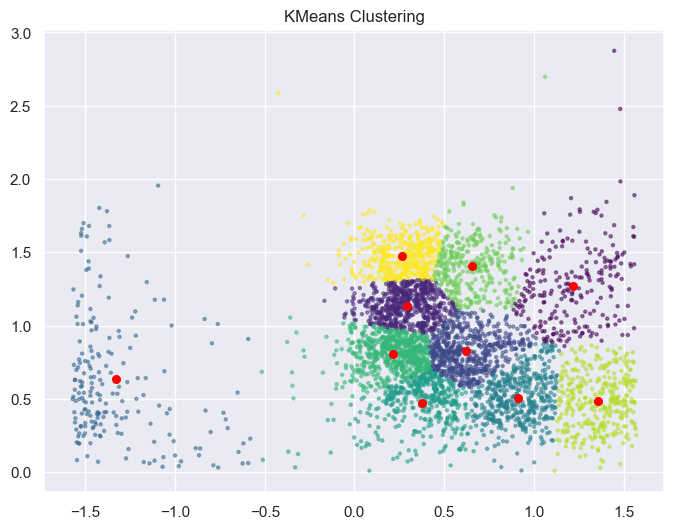

Cluster Centers:

[[ 1.21972155  1.2689947 ]
 [ 0.29100102  1.13668168]
 [ 0.62411771  0.82401711]
 [-1.32824504  0.63306756]
 [ 0.90890927  0.50943156]
 [ 0.37424201  0.47347474]
 [ 0.21732985  0.80800551]
 [ 0.65272006  1.40482196]
 [ 1.35664073  0.48464446]
 [ 0.26442341  1.47366069]]


In [60]:
kmeans = KMeans(n_clusters=10, n_init="auto", random_state=0)
km_clusters = kmeans.fit_predict(angles)
km_cluster_centers = kmeans.cluster_centers_
plt.figure(figsize=(8, 6))
plt.scatter(angles.iloc[:, 0], angles.iloc[:, 1], c=km_clusters, cmap='viridis', s=5, alpha=0.5)
plt.scatter(km_cluster_centers[:, 0], km_cluster_centers[:, 1], marker='o', c='red', s=30, label='Cluster centers')

plt.title('KMeans Clustering')

plt.grid(True)
plt.show()
print('Cluster Centers:')
print()
print(km_cluster_centers)

In [61]:
km_cluster_centers_indeces = []
for center in km_cluster_centers:
    distances = np.linalg.norm(angles - center, axis=1)
    index_closest_point = np.argmin(distances)
    km_cluster_centers_indeces.append(index_closest_point)

km_representative_data = conv_data1.iloc[km_cluster_centers_indeces, :]
km_representative_data

,Ro,Theta,Phi,3,4,5,6,7,8
3173,2.157708,1.201321,1.278973,-1.145,-21.146,-28.252,-243.43,53.36,1.0
2828,5.530339,0.287432,1.143136,-7.713,-7.692,5.898,-254.07,25.98,1.0
944,4.724831,0.620480,0.819664,-0.050,-1.099,3.159,-316.97,32.90,1.0
4147,4.274594,-1.312063,0.582534,1.312,-20.411,6.250,-205.65,39.08,1.0
2538,4.729509,0.904980,0.514071,15.488,-15.422,-8.168,-261.46,25.10,1.0
2213,6.760048,0.376875,0.459879,-8.757,7.300,-16.499,-270.56,45.90,1.0
413,7.430858,0.210557,0.805846,-5.313,5.559,14.809,-353.53,40.99,1.0
916,3.313597,0.653762,1.395157,14.791,9.813,-9.333,-318.12,43.33,1.0
1144,5.856269,1.359646,0.472491,-11.409,-13.782,-5.213,-307.63,42.32,1.0
2853,4.717083,0.266326,1.471672,23.245,-7.572,8.939,-253.51,31.46,1.0


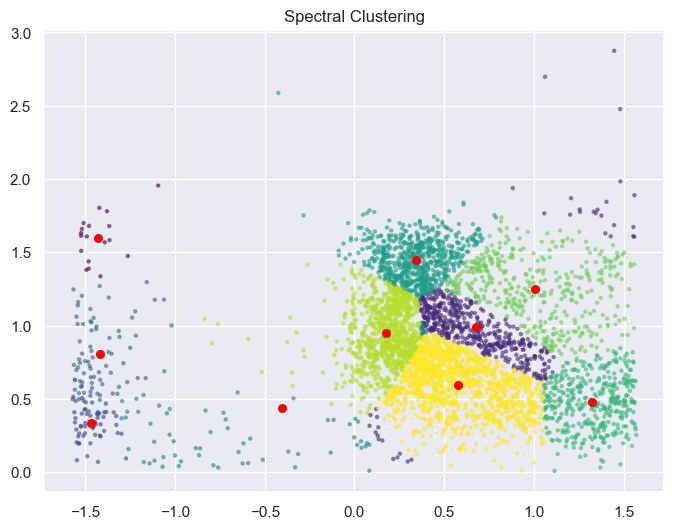

Cluster Centers:

[[-1.42877767  1.59961868]
 [ 0.67519479  0.99373183]
 [-1.46592092  0.33709218]
 [-1.4203952   0.81005058]
 [-0.40630738  0.43904999]
 [ 0.34512802  1.4509087 ]
 [ 1.32284499  0.47621369]
 [ 1.00711479  1.24883722]
 [ 0.17619862  0.95019624]
 [ 0.57613396  0.59642203]]


In [62]:
spectral = SpectralClustering(n_clusters=10, assign_labels='cluster_qr', random_state=state, n_neighbors=int(np.sqrt(angles.shape[0])))
s_clusters = spectral.fit_predict(angles)
plt.figure(figsize=(8, 6))
plt.scatter(angles.iloc[:, 0], angles.iloc[:, 1], c=s_clusters, cmap='viridis', s=5, alpha=0.5)

s_cluster_centers = np.zeros((10, 2))
for i in range(10): 
    s_cluster_points = angles[s_clusters == i]
    s_cluster_centers[i] = np.mean(s_cluster_points, axis=0)
plt.scatter(s_cluster_centers[:, 0], s_cluster_centers[:, 1], marker='o', c='red', s=30, label='Cluster centers')

plt.title('Spectral Clustering')

plt.grid(True)
plt.show()
print('Cluster Centers:')
print()
print(s_cluster_centers)

In [63]:
s_cluster_centers_indeces = []
for center in s_cluster_centers:
    distances = np.linalg.norm(angles - center, axis=1)
    index_closest_point = np.argmin(distances)
    s_cluster_centers_indeces.append(index_closest_point)

s_representative_data = conv_data1.iloc[s_cluster_centers_indeces, :]
s_representative_data

,Ro,Theta,Phi,3,4,5,6,7,8
1645,1.827513,-1.391646,1.568438,3.409,-3.014,10.629,-288.04,30.78,1.0
448,6.097210,0.675125,0.976159,2.885,-1.037,-9.872,-350.14,43.86,1.0
1070,4.007316,-1.463632,0.345676,5.160,-3.661,-1.622,-310.55,34.28,1.0
123,2.188438,-1.428364,0.807014,7.665,-0.984,10.706,-396.89,23.66,1.0
2985,0.563644,-0.339682,0.504218,4.483,-34.160,-4.365,-249.25,36.66,1.0
3484,5.278754,0.342673,1.440511,-11.544,8.916,12.921,-234.73,30.78,1.0
3671,5.751327,1.313902,0.482006,-6.311,-19.992,-4.390,-229.35,41.24,1.0
2245,2.136409,0.995475,1.249841,-5.849,5.589,8.111,-269.71,39.34,1.0
1449,7.605711,0.171195,0.956464,14.224,-17.923,-22.474,-294.91,45.64,1.0
451,5.302883,0.585344,0.595449,-11.780,2.317,-8.800,-349.87,29.81,1.0


### 3D Clustering

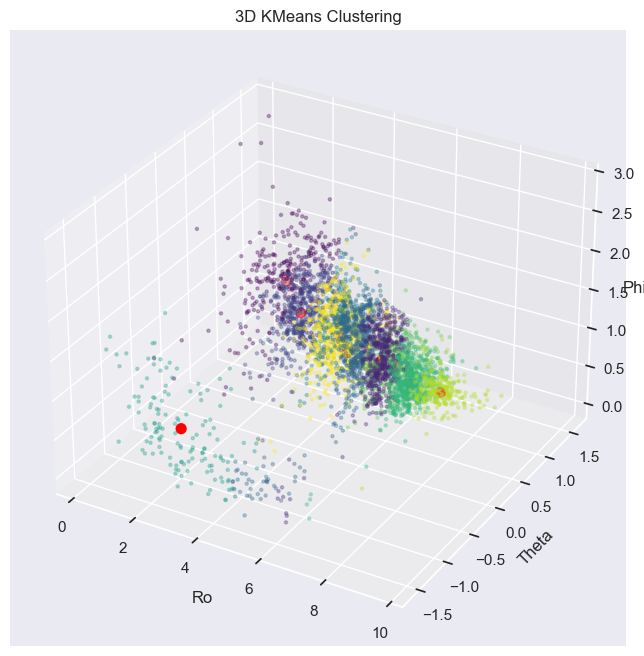


[[ 2.01711802  0.90497508  1.19697784]
 [ 6.19343307  0.27488939  1.02291709]
 [ 3.27734786  0.4673652   1.18663523]
 [ 5.27742843  0.18472025  1.07724099]
 [ 3.50328974  1.12711548  0.66244434]
 [ 2.70598774 -1.33265872  0.74978583]
 [ 6.9524786   0.38629871  0.7392727 ]
 [ 5.59542956  0.93039716  0.46757799]
 [ 7.9914367   0.32669053  0.79841882]
 [ 4.42062412  0.55858682  0.941809  ]]


In [64]:
tdkmeans = KMeans(n_clusters=10, n_init="auto", random_state=0)
tdkm_clusters = tdkmeans.fit_predict(coords)
tdkm_cluster_centers = tdkmeans.cluster_centers_
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(coords.iloc[:, 0], coords.iloc[:, 1], coords.iloc[:, 2], c=tdkm_clusters, cmap='viridis', s=5, alpha=0.3)
ax.scatter(tdkm_cluster_centers[:, 0], tdkm_cluster_centers[:, 1], tdkm_cluster_centers[:, 2], marker='o', c='red', s=50)
ax.set_xlabel('Ro')
ax.set_ylabel('Theta')
ax.set_zlabel('Phi', labelpad=-2)

plt.title('3D KMeans Clustering')

plt.grid(True)
plt.show()

print()
print(tdkm_cluster_centers)

In [65]:
tdkm_cluster_centers_indeces = []
for center in tdkm_cluster_centers:
    distances = np.linalg.norm(coords - center, axis=1)
    index_closest_point = np.argmin(distances)
    tdkm_cluster_centers_indeces.append(index_closest_point)

tdkm_representative_data = conv_data1.iloc[tdkm_cluster_centers_indeces, :]
tdkm_representative_data

,Ro,Theta,Phi,3,4,5,6,7,8
1442,1.997565,0.948323,1.252303,0.009,3.762,5.003,-295.21,37.38,1.0
3252,6.238618,0.275445,1.033511,16.088,-7.080,15.592,-241.23,36.25,1.0
1597,3.233393,0.496344,1.212921,3.597,4.206,-11.822,-289.53,42.09,1.0
3468,5.326082,0.177487,1.040781,-14.099,-0.708,7.500,-235.21,25.62,1.0
808,3.505178,1.152063,0.664997,9.102,-4.982,-9.553,-323.98,29.61,1.0
4050,2.584289,-1.369991,0.821352,-4.960,6.585,1.058,-212.08,24.00,1.0
1421,6.958750,0.381683,0.720803,4.604,15.356,-16.389,-296.01,45.45,1.0
3220,5.625252,0.879264,0.514919,-9.057,-13.155,-12.130,-242.09,35.62,1.0
306,7.995654,0.313583,0.823389,-11.064,12.260,7.976,-364.05,40.90,1.0
2101,4.444533,0.493515,0.962319,6.461,-11.432,3.002,-274.08,35.98,1.0


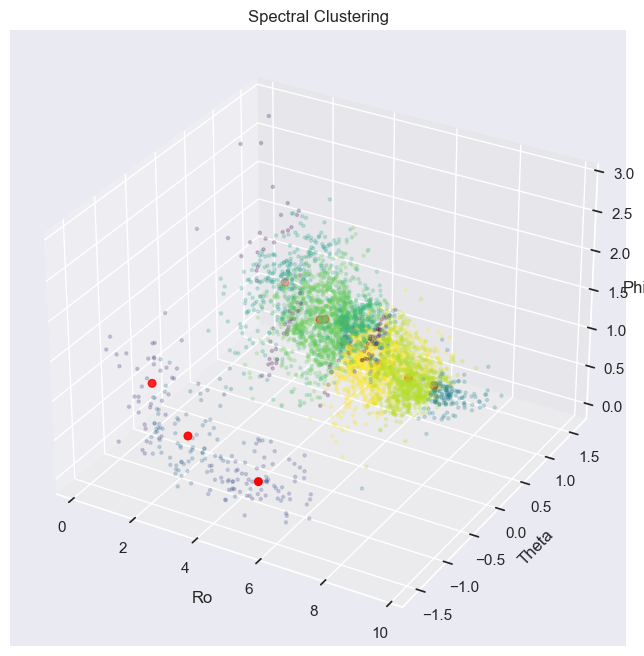

Cluster Centers:

[[ 3.85390667  0.59097485  1.09537539]
 [ 1.45133547 -1.15478541  1.06267314]
 [ 5.10781034 -1.31560109  0.36298165]
 [ 2.92894948 -1.33767821  0.68715828]
 [ 7.83830235  0.29054499  0.88918078]
 [ 2.0667166   0.8537854   1.21478549]
 [ 4.09941685  0.81378434  0.93409554]
 [ 3.97445979  0.42186682  1.20372933]
 [ 6.9185063   0.36032539  0.82819765]
 [ 5.43536373  0.67280264  0.64906293]]


In [66]:
tdspectral = SpectralClustering(n_clusters=10, assign_labels='cluster_qr', random_state=state, n_neighbors=int(np.sqrt(coords.shape[0])))
tds_clusters = tdspectral.fit_predict(coords)
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(coords.iloc[:, 0], coords.iloc[:, 1], coords.iloc[:, 2], c=tds_clusters, cmap='viridis', s=5, alpha=0.2)

tds_cluster_centers = np.zeros((10, 3))
for i in range(10): 
    tds_cluster_points = coords[tds_clusters == i]
    tds_cluster_centers[i] = np.mean(tds_cluster_points, axis=0)
ax.scatter(tds_cluster_centers[:, 0], tds_cluster_centers[:, 1], tds_cluster_centers[:, 2], marker='o', c='red', s=30)
ax.set_xlabel('Ro')
ax.set_ylabel('Theta')
ax.set_zlabel('Phi', labelpad=-2)
plt.title('Spectral Clustering')

plt.grid(True)
plt.show()
print('Cluster Centers:')
print()
print(tds_cluster_centers)

In [67]:
tds_cluster_centers_indeces = []
for center in tds_cluster_centers:
    distances = np.linalg.norm(coords - center, axis=1)
    index_closest_point = np.argmin(distances)
    tds_cluster_centers_indeces.append(index_closest_point)

tds_representative_data = conv_data1.iloc[tds_cluster_centers_indeces, :]
tds_representative_data

,Ro,Theta,Phi,3,4,5,6,7,8
1865,3.863003,0.549742,1.152709,-11.030,-11.843,0.066,-281.10,42.33,1.0
3118,1.547732,-1.061087,1.177371,21.358,0.649,11.371,-245.59,26.38,1.0
3904,5.062211,-1.394146,0.409310,16.120,-12.477,-11.291,-219.07,43.73,1.0
2965,2.933445,-1.468556,0.647866,10.693,-15.727,6.603,-249.87,32.91,1.0
2025,7.841542,0.334816,0.890674,2.269,17.238,14.818,-276.43,42.27,1.0
3107,1.989696,0.812857,1.153937,-3.965,21.388,-12.459,-245.93,41.50,1.0
241,4.078643,0.732837,0.863382,5.906,-7.206,-10.175,-371.78,37.44,1.0
2970,4.024770,0.409298,1.224823,11.739,-9.918,-20.967,-249.76,40.85,1.0
836,6.913953,0.372138,0.799548,-9.108,4.763,-1.945,-322.42,44.25,1.0
54,5.438466,0.679748,0.608193,-6.489,3.610,-11.357,-419.32,29.25,1.0


### We notice however that there's no agreement between the various methods:

In [68]:
print(set(km_cluster_centers_indeces).intersection(s_cluster_centers_indeces), set(km_cluster_centers_indeces).intersection(tdkm_cluster_centers_indeces), \
set(km_cluster_centers_indeces).intersection(tds_cluster_centers_indeces), set(s_cluster_centers_indeces).intersection(tdkm_cluster_centers_indeces), \
set(s_cluster_centers_indeces).intersection(tds_cluster_centers_indeces), set(tdkm_cluster_centers_indeces).intersection(tds_cluster_centers_indeces))

set() set() set() set() set() set()


In [69]:
set(km_cluster_centers_indeces).intersection(s_cluster_centers_indeces, tdkm_cluster_centers_indeces, tds_cluster_centers_indeces)

set()

This was expected, as it's difficult that different clustering methods give the exacly same cluster centers. How do we choose the 10 best ones on the basis of the results? Out approach will be the following:

- we consider the results that don't involve the radius, as it is not relevant for our study;
- whe choose the clustering results that leads to the highest silhouette score.

In [103]:
# Calcola l'indice silhouette per i risultati di K-Means
kmeans_silhouette_score = silhouette_score(angles, km_clusters)

# Calcola l'indice silhouette per i risultati di Spectral Clustering
spectral_silhouette_score = silhouette_score(angles, s_clusters)

print("Indice silhouette per K-Means:", kmeans_silhouette_score)
print("Indice silhouette per Spectral Clustering:", spectral_silhouette_score)

Indice silhouette per K-Means: 0.3490933604813492
Indice silhouette per Spectral Clustering: 0.29817744370241417


Therefore, we choose the centers obtained with K-means. 

In [105]:
km_representative_data

,Ro,Theta,Phi,3,4,5,6,7,8
3173,2.157708,1.201321,1.278973,-1.145,-21.146,-28.252,-243.43,53.36,1.0
2828,5.530339,0.287432,1.143136,-7.713,-7.692,5.898,-254.07,25.98,1.0
944,4.724831,0.620480,0.819664,-0.050,-1.099,3.159,-316.97,32.90,1.0
4147,4.274594,-1.312063,0.582534,1.312,-20.411,6.250,-205.65,39.08,1.0
2538,4.729509,0.904980,0.514071,15.488,-15.422,-8.168,-261.46,25.10,1.0
2213,6.760048,0.376875,0.459879,-8.757,7.300,-16.499,-270.56,45.90,1.0
413,7.430858,0.210557,0.805846,-5.313,5.559,14.809,-353.53,40.99,1.0
916,3.313597,0.653762,1.395157,14.791,9.813,-9.333,-318.12,43.33,1.0
1144,5.856269,1.359646,0.472491,-11.409,-13.782,-5.213,-307.63,42.32,1.0
2853,4.717083,0.266326,1.471672,23.245,-7.572,8.939,-253.51,31.46,1.0
